<a href="https://colab.research.google.com/github/Alice1304/1day1commit/blob/main/%EC%8B%A4%EC%8A%B5/SECTION4/N433.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EX1 : 기본적인 AutoEncoder 

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#데이터 셋을 불러온 뒤 정규화하기 
#레이블을 따로 사용하지 않기 때문에 _처리 함


(x_train, _), (x_test, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


1. AutoEncoder 모델을 구축하기

In [5]:
# 잠재 벡터(Latent vector)의 차원 수를 정해줍니다.
LATENT_DIM = 64

In [6]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),   #펴주기 
            layers.Dense(latent_dim, activation='relu'),])  #64차원으로으로 줄여주게 됨
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),  # 디코딩 과정
            layers.Reshape((28, 28)) 
        ])

    def call(self, x):
        encoded = self.encoder(x) #인코더
        decoded = self.decoder(encoded) #디코더
        return decoded

In [7]:
model = Autoencoder(LATENT_DIM)   #Autoencoder를 model에 저장해주기 

2. 모델 컴파일 후 학습하기 



In [8]:
model.compile(optimizer='adam', loss='mse')

In [9]:
model.fit(x_train, x_train,
          epochs=10,
          shuffle=True,
          validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 12s 4ms/step - loss: 0.0239 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.00

3. 학습된 모델을 사용하여 시험(test) 이미지를 인코딩 후 디코딩하여줍니다.

In [10]:
encoded_imgs = model.encoder(x_test).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy() #인코딩 / 디코딩

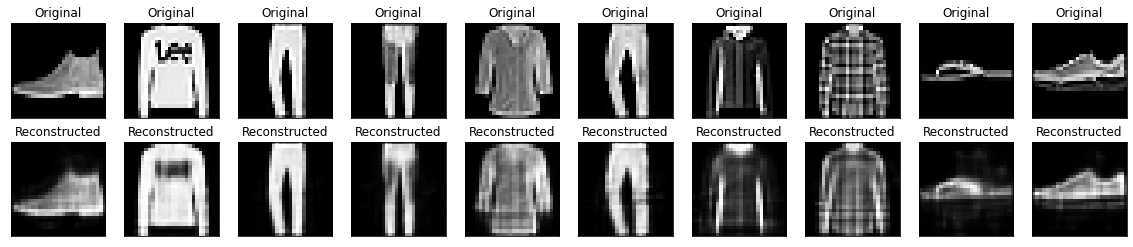

In [11]:
n = 10

plt.figure(figsize=(20, 4))

for i in range(n):
    # 원본 이미지를 출력합니다.
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # AutoEncoder에 의해서 복원된 이미지를 출력합니다.
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## EX2 : DAE(Denoising AutoEncoder)


**1. 데이터셋을** 불러온 뒤 정규화 하여줍니다.

*   이번에는 Encoder/Decoder 에서 완전 연결 신경망(Dense)이 아닌 Convolution 층(Conv2D)을 사용해보겠습니다.
*   이러한 AutoEncoder 를 Convolutional AutoEncoder 라고도 부릅니다.
*   데이터셋을 Convolutional AutoEncoder 에 적용하기 위해서는 데이터에 임의의 채널을 더하는 과정이 필요합니다.



In [12]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [14]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [15]:
print(x_train.shape) #임의의 채널 더하는 과정 추가

(60000, 28, 28, 1)


2. Random Noise 추가

모델이 Noise 있는 이미지 데이터를 입력받을 수 있도록 임의의 Noise 를 추가합니다.
Noise를 추가한 이미지를 시각화 해봅니다.

In [16]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

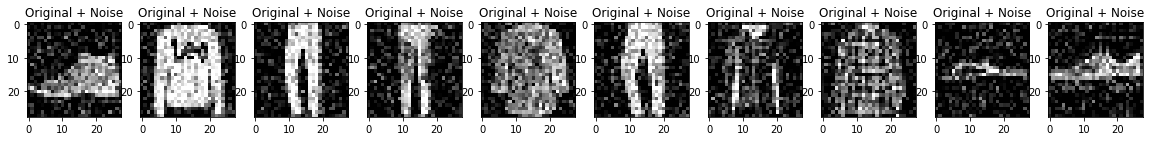

In [17]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("Original + Noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

3. Denoising AutoEncoder 모델을 구축합니다.

In [18]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)), 
            layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2), #dense 대신 conv2d 사용 다운샘플링
            layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),   #트랜스포즈 사용 원래이미지의 크기로 돌려놓기 
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Denoise()  #클래스를 객체로 받아서 저장

In [19]:
model.compile(optimizer='adam', loss='mse')

In [20]:
model.fit(x_train_noisy, x_train,
          epochs=10,
          shuffle=True,
          validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 16s 4ms/step - loss: 0.0160 - val_loss: 0.0090
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.00

In [21]:
model.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


3. 학습된 모델을 사용하여 시험(test) 이미지를 인코딩 후 디코딩하여줍니다.

In [23]:
encoded_imgs = model.encoder(x_test).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

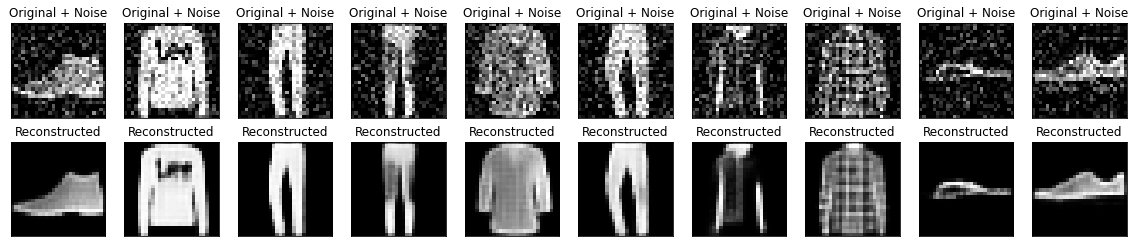

In [24]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # Noise가 추가된 원본 이미지를 출력합니다.
    ax = plt.subplot(2, n, i + 1)
    plt.title("Original + Noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # AutoEncoder에 의해서 복원된 이미지를 출력합니다.
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("Reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## EX3 : 이상치 탐지(Anomaly Detection)

비정상 데이터를 탐지하기 위한 이상치 탐지(Anomaly Detection)에도 AutoEncoder 를 사용할 수 있습니다.
AutoEncoder는 특정 데이터의 중요 특징, 즉 잠재 벡터를 바탕으로
다시 원본 데이터로 복원할 때에 발생하는 오류, 즉 복원 오류(Reconstruction Error)를 최소화 하도록 훈련됩니다.

정상 데이터로만 훈련한 뒤에 비정상 데이터셋을 복원한다면 복원 오류가 커질 것입니다.
복원 오류가 특정한 임계값을 초과하는 경우 해당 데이터를 비정상으로 판단할 수 있습니다.

이번 예제에서는 심전도를 측정한 데이터셋인 ECG 5000을 사용할 것입니다.
해당 데이터는 140개의 Feature를 가지고 있으며 크기는 5,000개 입니다.
141번째 Column은 비정상 데이터(0)와 정상 데이터(1)를 구분하는 역할을 합니다.
정상 데이터로 훈련 후에 비정상 데이터를 제대로 구분해낼 수 있는지 알아보도록 하겠습니다.

In [25]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

1.  데이터 다운로드, 전처리 및 분리 

In [26]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df_value=df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [27]:
label = df_value[:, -1] #타겟
data = df_value[:, 0:-1]  #데이터 

In [28]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

2. 데이터셋 정규화
- MinMaxScaling 방식 적용

In [29]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

3. 정상 데이터셋과 비정상 데이터셋 분리하기

In [30]:
#모델 학습할 때는 1로 레이블이 지정된 정상 데이터만 사용

train_label = train_label.astype(bool)
test_label = test_label.astype(bool)

normal_train_data = train_data[train_label]
normal_test_data = test_data[test_label]

anomalous_train_data = train_data[~train_label]
anomalous_test_data = test_data[~test_label]

4. 정상 데이터셋과 비정상 데이터셋 중 특정 데이터 각각 시각화 

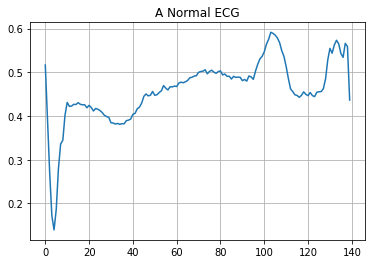

In [31]:
# 정상데이터 

plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

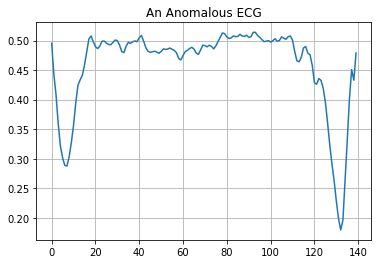

In [32]:
# 비정상 데이터 
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

5. AutoEncoder 모델 구축

손실함수로 mae사용
학습 시에는 정상데이터만 사용하기

In [33]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")])    # 마지막 층은 원본 데이터의 차원 수와 동일하게 맞추어줍니다.
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = AnomalyDetector()

In [34]:
model.compile(optimizer='adam', loss='mae')

In [35]:
history = model.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 58ms/step - loss: 0.0570 - val_loss: 0.0529
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0536 - val_loss: 0.0511
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0497 - val_loss: 0.0486
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0456 - val_loss: 0.0464
Epoch 5/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0420 - val_loss: 0.0442
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0389 - val_loss: 0.0426
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0359 - val_loss: 0.0413
Epoch 8/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0331 - val_loss: 0.0401
Epoch 9/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0308 - val_loss: 0.0388
Epoch 10/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0288 - val_loss: 0.0378
Epoch 11/20
5/5 [============

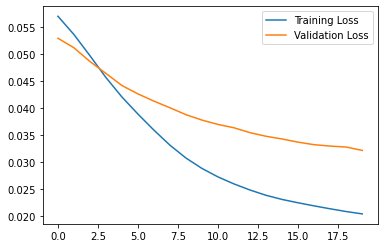

In [36]:
#학습곡선 시각화

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

6. autoencoder사용하여 복원 오류 시각화하기 

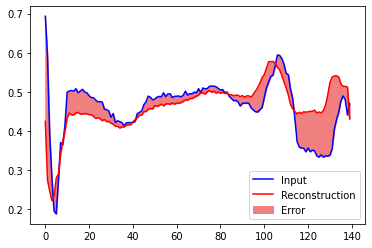

In [37]:
#정상 데이터와 AutoEncoder에 의한 복원을 비교한 그래프를 Plot
encoded_imgs = model.encoder(normal_test_data).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

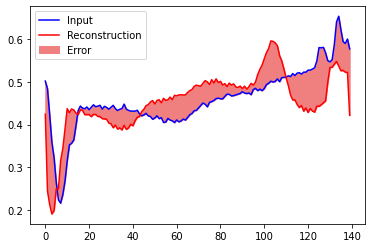

In [38]:
#비정상 데이터와 AutoEncoder에 의한 복원을 비교한 그래프를 Plot

encoded_imgs = model.encoder(anomalous_test_data).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

7. 이상치 판단하기 

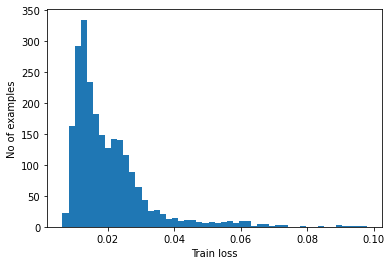

In [39]:
#정상데이터 오차 시각화

reconstructions = model.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [40]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.031840213


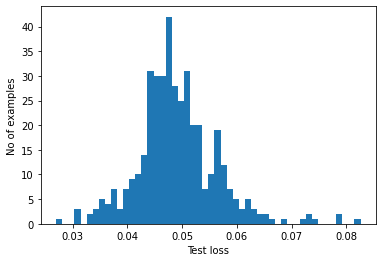

In [41]:
#비정상데이터 오차 시각화

reconstructions = model.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()